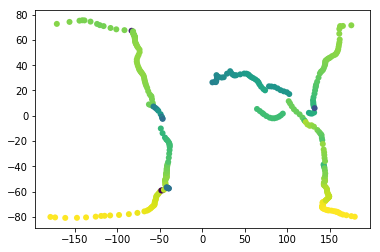

In [4]:
import pygplates
import pandas as pd
import sys
sys.path.append('/Users/Simon/GIT/PlateTectonicTools/')
import ptt.subduction_convergence as sc
import matplotlib.pyplot as plt

%matplotlib inline

class ReconstructionModel(object):
    
    def __init__(self, name):
        self.name = name
        self.rotation_model = []    # creates a new empty list for each dog
        self.static_polygons = []
        self.dynamic_polygons = []

    def add_rotation_model(self, rotation_file):
        self.rotation_model.append(rotation_file)
        
    def add_static_polygons(self, static_polygons_file):
        self.static_polygons.append(static_polygons_file)
        
    def add_dynamic_polygons(self, dynamic_polygons_file):
        self.dynamic_polygons.append(dynamic_polygons_file)
        
    def subduction_convergence(self, reconstruction_time, 
                              velocity_delta_time=1.,
                              threshold_sampling_distance_radians=2,
                              anchor_plate_id=0):

        result = sc.subduction_convergence(
            self.rotation_model,
            self.dynamic_polygons,
            threshold_sampling_distance_radians,
            reconstruction_time,
            velocity_delta_time,
            anchor_plate_id)
        
        # Make a flat list of subduction stats to input into the proximity test
        subduction_data = []
        for data in result:
            subduction_data.append(data+(reconstruction_time,))
    
        # Data frame template defining the column names
        DataFrameTemplate = ('lon','lat','conv_rate','conv_obliq','migr_rate',
                             'migr_obliq','arc_length','arc_azimuth',
                             'subducting_plate','overriding_plate','time')
        
        # convert list array to dataframe
        df = pd.DataFrame(subduction_data, columns = DataFrameTemplate)
        
        return SubductionConvergence(df)
        
        
    #def 

class SubductionConvergence(object):
    
    def __init__(self, df):
        self.df = df
    

    def plot(self):
        plt.figure()
        plt.scatter(self.df.lon, self.df.lat,c=self.df.conv_rate,edgecolors='')
        plt.show()

    
    
a = ReconstructionModel('Matthews++2016')
a.add_rotation_model('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
a.add_static_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')
a.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz')
a.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')
a.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz')
#a.subduction_convergence(...).plot()
#print a.dynamic_polygons


data = a.subduction_convergence(120.,threshold_sampling_distance_radians=5.)

data.plot()


In [23]:
class age_coded_point_dataset(object):
    
    def __init__(self, df, longitude_field, latitude_field, age_field):
        self.df = df
        self.point_features = []
        for index,row in df.iterrows():
            point = pygplates.PointOnSphere(float(row[latitude_field]),float(row[longitude_field]))
            point_feature = pygplates.Feature()
            point_feature.set_geometry(point)
            point_feature.set_valid_time(row[age_field],-999.)
            self.point_features.append(point_feature)
        
            
    def assign_reconstruction_model(self,reconstruction_model):
        partitioned_point_features = pygplates.partition_into_plates(reconstruction_model.static_polygons,
                                                                     reconstruction_model.rotation_model,
                                                                     self.point_features)
        self.point_features = partitioned_point_features
        self.reconstuction_model = reconstruction_model
    
    
    def reconstruct(self,reconstruction_time):
        reconstructed_features = []
        pygplates.reconstruct(self.point_features,
                              self.reconstuction_model.rotation_model,
                              reconstructed_features,
                              reconstruction_time)
        
        return reconstructed_features
    
    def plot_reconstructed(self,reconstruction_time):
        reconstructed_features = []
        pygplates.reconstruct(self.point_features,
                              self.reconstuction_model.rotation_model,
                              reconstructed_features,
                              reconstruction_time)
        
        plt.figure()
        for reconstructed_feature in reconstructed_features:
            plt.plot(reconstructed_feature.get_geometry().get_longitude(),
                     reconstructed_feature.get_geometry().get_latitude(),'o')
        plt.show()
        
    

df = pd.read_csv('/Users/Simon/Data/TimeEncodedData/Yanites+Kesler/ngeo2429-s2.csv',index_col='Deposit number')

#df

t = age_coded_point_dataset(df,'Long.','Lat.','Age (Ma)')

t.assign_reconstruction_model(a)

rt = t.reconstruct(120.)

#t.plot_reconstructed(120.)

print rt

plt.figure()
for reconstructed_feature in rt:
    print reconstructed_feature.get_geometry().get_longitude()
    plt.plot(reconstructed_feature.get_geometry().get_longitude(),
             reconstructed_feature.get_geometry().get_latitude(),'o')
plt.show()


[]


<Figure size 432x288 with 0 Axes>